## Spam detection

1. Read dataset and make it in proper format.
2. Encode labels
3. Convert all cases to lower
4. Remove punctuations
5. Remove Stopwords
6. Check stats of messages
7. Convert all texts into vectors
8. Import classifier
9. Train and test
10. Check the accuracy/confusion matrix.


In [1]:
#Import libs
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
sms = pd.read_csv('spam.csv',encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Dataset has extra columns- Remove 
# Renaming v1 and v2
sms.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
sms.rename(columns={'v1':'label','v2':'message'},inplace=True)

In [4]:
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
print ('Shape = >',sms.shape)

Shape = > (5572, 2)


In [6]:
print ('ham and spam counts','\n',sms.label.value_counts())

ham and spam counts 
 ham     4825
spam     747
Name: label, dtype: int64


In [7]:
#Ratio
print ('spam ratio = ', round(len(sms[sms['label']=='spam']) / len(sms.label),2)*100,'%')
print ('ham ratio  = ', round(len(sms[sms['label']=='ham']) / len(sms.label),2)*100,'%')

spam ratio =  13.0 %
ham ratio  =  87.0 %


In [8]:
#New column for Length of message
sms['length'] = sms.message.str.len()
sms.head(2)

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29


In [9]:
#Label coding 0 and 1
sms['label'].replace({'ham':0,'spam':1},inplace=True)

In [10]:
# Convert all messages to lower case
sms['message'] = sms['message'].str.lower()

In [11]:
# Replace email addresses with 'email'
sms['message'] = sms['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
sms['message'] = sms['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
sms['message'] = sms['message'].str.replace(r'£|\$', 'moneysymb')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
sms['message'] = sms['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')

    
# Replace numbers with 'numbr'
sms['message'] = sms['message'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [12]:
# Remove punctuation
sms['message'] = sms['message'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
sms['message'] = sms['message'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
sms['message'] = sms['message'].str.replace(r'^\s+|\s+?$', '')

In [13]:
sms.head()

,label,message,length
0,0,go until jurong point crazy available only in ...,111
1,0,ok lar joking wif u oni,29
2,1,free entry in numbr a wkly comp to win fa cup ...,155
3,0,u dun say so early hor u c already then say,49
4,0,nah i don t think he goes to usf he lives arou...,61


In [14]:
# Remove stopwords
import string
import nltk
from nltk.corpus import  stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

sms['message'] = sms['message'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

In [15]:
# New column (clean_length) after puncuations,stopwords removal
sms['clean_length'] = sms.message.str.len()
sms.head()

,label,message,length,clean_length
0,0,go jurong point crazy available bugis n great ...,111,82
1,0,ok lar joking wif oni,29,21
2,1,free entry numbr wkly comp win fa cup final tk...,155,139
3,0,dun say early hor c already say,49,31
4,0,nah think goes usf lives around though,61,38


In [16]:
# Total length removal
print ('Origian Length', sms.length.sum())
print ('Clean Length', sms.clean_length.sum())

Origian Length 446422
Clean Length 301266


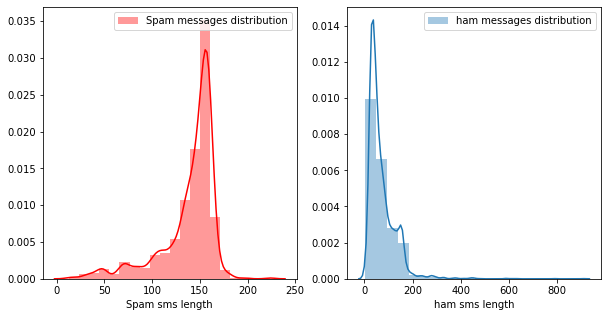

In [17]:
# Message distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (10,5))

sns.distplot(sms[sms['label']==1]['length'],bins=20,ax=ax[0],label='Spam messages distribution',color='r')
ax[0].set_xlabel('Spam sms length')
ax[0].legend()

sns.distplot(sms[sms['label']==0]['length'],bins=20,ax=ax[1],label='ham messages distribution')
ax[1].set_xlabel('ham sms length')
ax[1].legend()

plt.show()

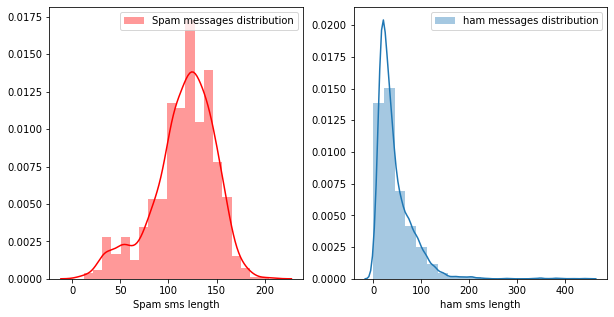

In [18]:
# Message distribution AFTER cleaning
f,ax = plt.subplots(1,2,figsize = (10,5))

sns.distplot(sms[sms['label']==1]['clean_length'],bins=20,ax=ax[0],label='Spam messages distribution',color='r')
ax[0].set_xlabel('Spam sms length')
ax[0].legend()

sns.distplot(sms[sms['label']==0]['clean_length'],bins=20,ax=ax[1],label='ham messages distribution')
ax[1].set_xlabel('ham sms length')
ax[1].legend()

plt.show()

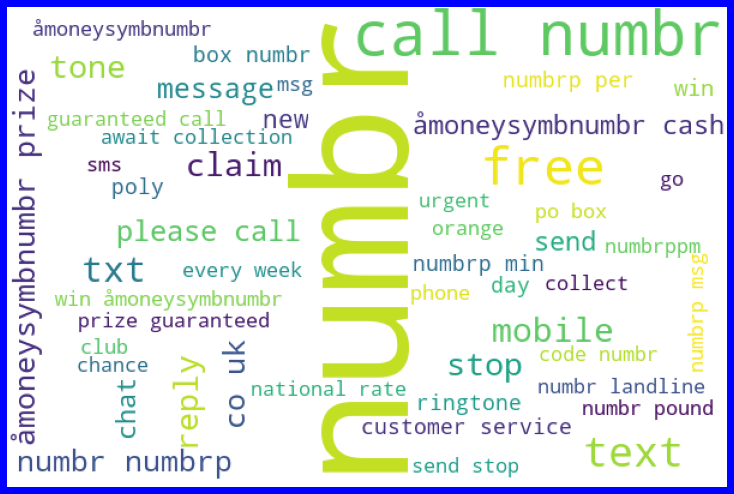

In [19]:
#Getting sense of loud words in spam
from wordcloud import WordCloud


spams = sms['message'][sms['label']==1]
spam_cloud = WordCloud(width=600,height=400,background_color='white',max_words=50).generate(' '.join(spams))
plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

We can clearly see, some of the words like "free, claim,cash etc" are indication of spams.

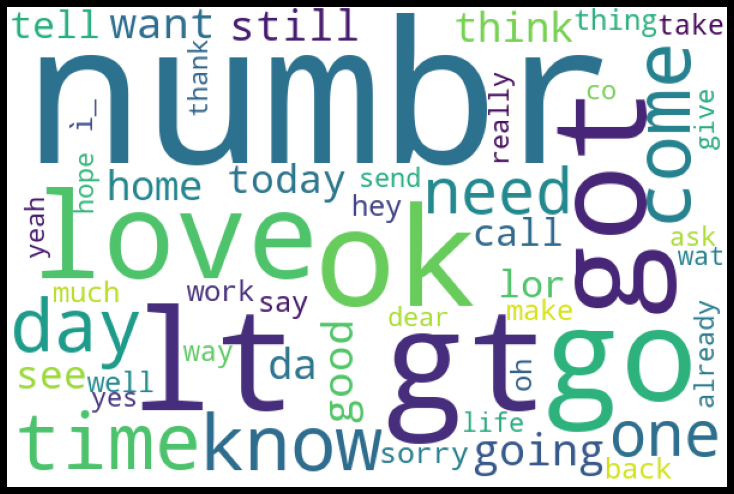

In [20]:
#Getting sense of loud words in ham 

hams = sms['message'][sms['label']==0]
spam_cloud = WordCloud(width=600,height=400,background_color='white',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [21]:
# 1. Convert text into vectors using TF-IDF
# 2. Instantiate MultinomialNB classifier
# 3. Split feature and label
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tf_vec = TfidfVectorizer()
naive = MultinomialNB()

features = tf_vec.fit_transform(sms['message'])

X = features
y = sms['label']

In [22]:
# Train and predict
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)
naive.fit(X_train,Y_train)
y_pred= naive.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.9705671213208902


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1202
           1       1.00      0.79      0.88       191

    accuracy                           0.97      1393
   macro avg       0.98      0.89      0.93      1393
weighted avg       0.97      0.97      0.97      1393



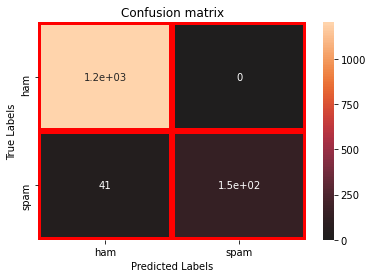

In [24]:
# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()
sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['ham','spam'])
ax.yaxis.set_ticklabels(['ham','spam'])
plt.show()